# Eye-Tracking Plotting Overview

Purpose
- Visualize key eye-tracking features per session as quality and behavior overview.

Inputs
- `./preprocessed/eye_tracking_features.csv` generated by `06_EyeEvents.ipynb`.

Quality Filters (applied before plotting)
- `roi_coverage >= 20` (% of gaze points inside text ROI)
- `pupil_size_mean >= 100` (remove blinks / tracking dropouts)
- `fixation_duration_mean <= 1.5 s` (cap unrealistic long fixations)

Outputs
- 2×3 boxplot grid by `session_id` for:
  - ROI Coverage (%), Number of Fixations, Mean Fixation Duration (s)
  - Number of Saccades, Mean Saccade Amplitude (px), Mean Pupil Size
- Saved to `./figures/eye_tracking_features_by_session_filtered.png`
- Displayed inline in notebook

Notes
- You can adjust filter thresholds in the parameters cell where `MIN_ROI`, `MIN_PUPIL`, and `MAX_FIX_DUR` are defined.
- For condition-wise plots (e.g., `alignment`), we can extend this notebook with additional facets.

Citation
- Based on analysis workflow adapted from: Chiossi, F., Mayer, S., & Ou, C. (2024). OSF: https://osf.io/fncj4/ (GPL-3.0).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
file_path = "./preprocessed/eye_tracking_features.csv"

df = pd.read_csv(file_path)
print("Loaded:", file_path, "shape=", df.shape)


Loaded: ./preprocessed/eye_tracking_features.csv shape= (45, 18)


In [3]:
print(sorted(df.columns.tolist()))
print("Sessions:", sorted(df['session_id'].unique().tolist()))

# Quality filters
MIN_ROI = 20.0         # % of gaze points inside ROI
MIN_PUPIL = 100.0      # raw pupil size threshold to remove blinks/dropouts
MAX_FIX_DUR = 1.5      # seconds; cap unrealistic long fixations

filtered = (
    df
      .query("roi_coverage >= @MIN_ROI")
      .query("pupil_size_mean >= @MIN_PUPIL")
      .query("fixation_duration_mean <= @MAX_FIX_DUR")
      .copy()
)
print(f"Filtered from {len(df)} to {len(filtered)} trials")


['alignment', 'duration', 'fixation_count', 'fixation_dispersion_x', 'fixation_dispersion_y', 'fixation_duration_mean', 'fixation_duration_total', 'pupil_size_mean', 'pupil_size_std', 'roi_coverage', 'saccade_amplitude_max', 'saccade_amplitude_mean', 'saccade_count', 'saccade_velocity_mean', 'session_id', 'time_to_first_fixation', 'trial_idx', 'trial_n']
Sessions: [0, 1, 4]
Filtered from 45 to 29 trials


✓ Saved figure to ./figures/eye_tracking_features_by_session_filtered.png


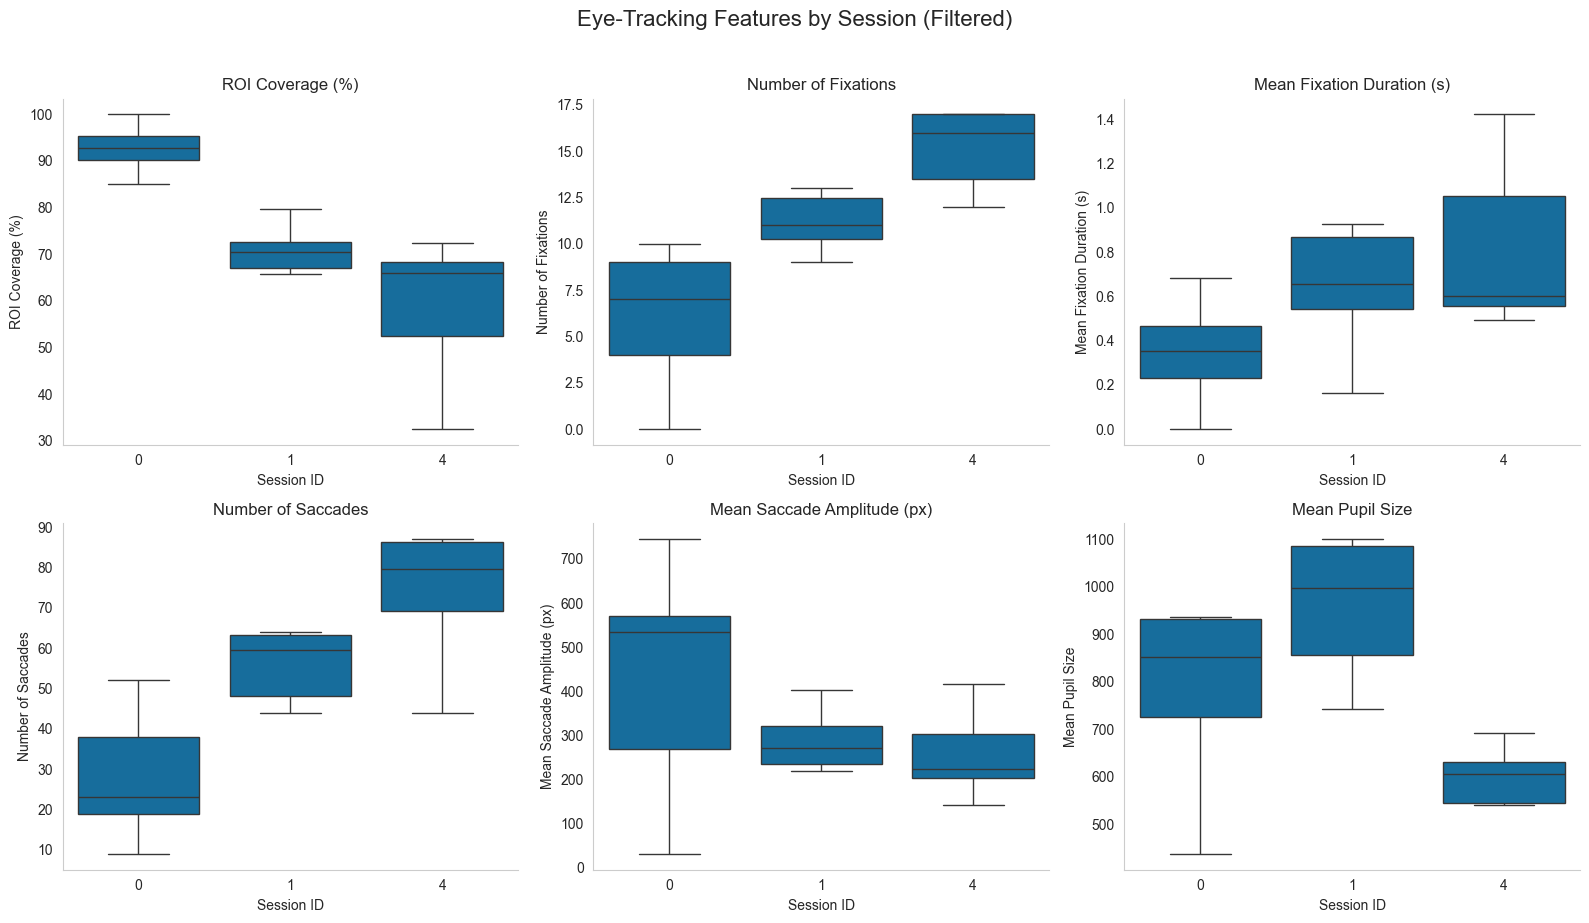

In [4]:
sns.set_palette("colorblind")
sns.set_style("whitegrid", {"axes.grid": False})

metrics = [
    ("roi_coverage", "ROI Coverage (%)"),
    ("fixation_count", "Number of Fixations"),
    ("fixation_duration_mean", "Mean Fixation Duration (s)"),
    ("saccade_count", "Number of Saccades"),
    ("saccade_amplitude_mean", "Mean Saccade Amplitude (px)"),
    ("pupil_size_mean", "Mean Pupil Size"),
]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for ax, (col, label) in zip(axes, metrics):
    sns.boxplot(x=filtered['session_id'].astype(str), y=filtered[col], showfliers=False, ax=ax)
    ax.set_xlabel('Session ID')
    ax.set_ylabel(label)
    ax.set_title(label)
    sns.despine(ax=ax)

fig.suptitle('Eye-Tracking Features by Session (Filtered)', fontsize=16, y=1.02)
fig.tight_layout()

# Save figure
output_path = "./figures/eye_tracking_features_by_session_filtered.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved figure to {output_path}")

plt.show()


## Spatial Gaze Distribution (Heatmaps)

Visualize where participants looked on the screen across all trials per session.

✓ Saved heatmap to ./figures/eye_tracking_heatmaps_by_session.png


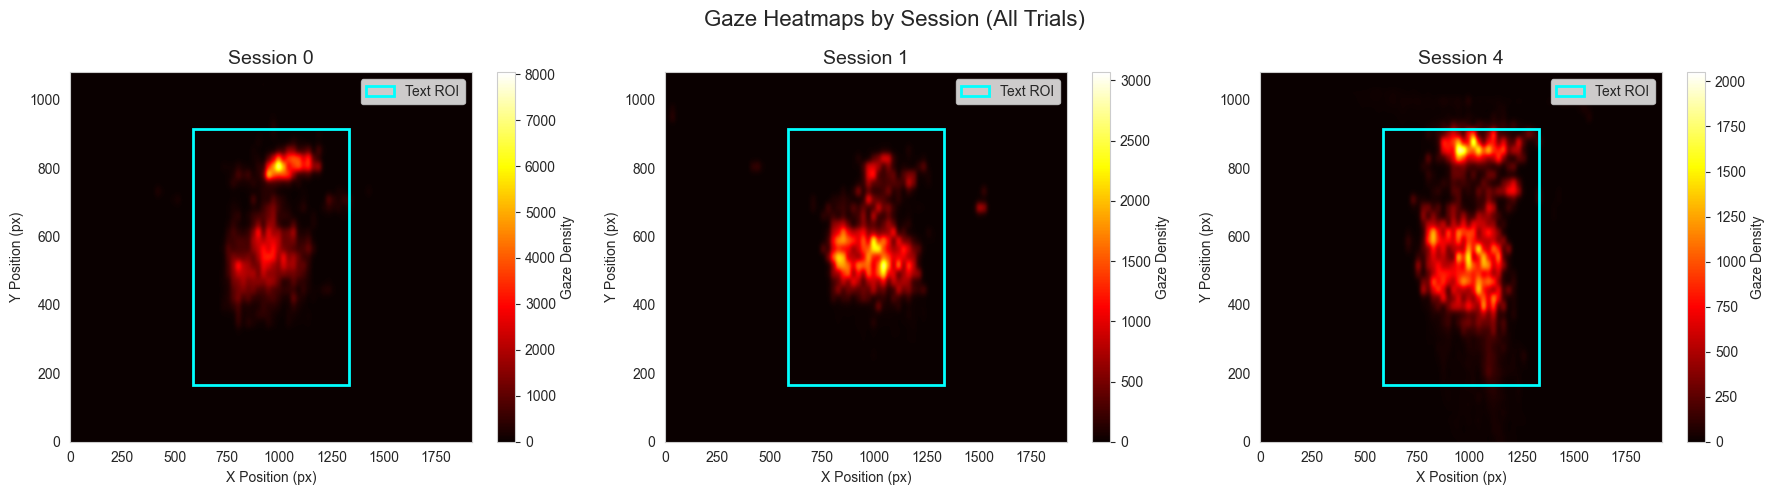

In [5]:
import pickle
import numpy as np

# Load session-level trial data
session_files = {
    0: "./preprocessed/session_00-eye.pkl",
    1: "./preprocessed/session_01-eye.pkl",
    4: "./preprocessed/session_04-eye.pkl",
}

# Screen dimensions (from 06_EyeEvents.ipynb)
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
ROI_X1, ROI_Y1 = 585, 165
ROI_X2, ROI_Y2 = 1335, 915

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (session_id, filepath) in zip(axes, session_files.items()):
    with open(filepath, 'rb') as f:
        trials = pickle.load(f)
    
    # Collect all gaze points across trials
    all_x, all_y = [], []
    for trial in trials:
        samples = trial['samples']
        # Use left eye (or average if you prefer)
        x = samples['x_left'].dropna()
        y = samples['y_left'].dropna()
        all_x.extend(x.values)
        all_y.extend(y.values)
    
    # Create 2D histogram (heatmap)
    heatmap, xedges, yedges = np.histogram2d(
        all_x, all_y,
        bins=[80, 45],  # ~24px per bin horizontally, ~24px vertically
        range=[[0, SCREEN_WIDTH], [0, SCREEN_HEIGHT]]
    )
    
    # Plot
    im = ax.imshow(
        heatmap.T,
        origin='lower',
        extent=[0, SCREEN_WIDTH, 0, SCREEN_HEIGHT],
        cmap='hot',
        aspect='auto',
        interpolation='gaussian'
    )
    
    # Draw ROI rectangle
    from matplotlib.patches import Rectangle
    roi_rect = Rectangle(
        (ROI_X1, ROI_Y1), ROI_X2 - ROI_X1, ROI_Y2 - ROI_Y1,
        linewidth=2, edgecolor='cyan', facecolor='none', label='Text ROI'
    )
    ax.add_patch(roi_rect)
    
    ax.set_title(f'Session {session_id}', fontsize=14)
    ax.set_xlabel('X Position (px)')
    ax.set_ylabel('Y Position (px)')
    ax.legend(loc='upper right')
    plt.colorbar(im, ax=ax, label='Gaze Density')

fig.suptitle('Gaze Heatmaps by Session (All Trials)', fontsize=16)
fig.tight_layout()

# Save
heatmap_path = "./figures/eye_tracking_heatmaps_by_session.png"
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved heatmap to {heatmap_path}")

plt.show()
